In [0]:
try:
    import torchgan
except:
    !pip install torchgan

In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST, FashionMNIST
from torch.autograd import Variable
from torchgan.metrics import ClassifierScore
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
# Define constants
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
sample_interval = 400
img_size = 28
channels = 1
img_shape = (channels, img_size, img_size)
n_critic = 5
clip_value = 0.01
lambda_gp = 10
device = 'cuda'
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [0]:
# Original WGAN-GP (from Pytorch-GAN: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [0]:
# from same source stated above
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [0]:
#original mnist dataset
mnist = MNIST("../../data", train=True, download=True, 
              transform=transforms.Compose(
              [transforms.ToTensor(), transforms.Normalize([0.5], [0.5], inplace=False)]))

In [0]:
#block pixels
def block_pixels(imgs, p):
    p_mask = torch.full(imgs.size(), p)
    mask = torch.bernoulli(p_mask).to(torch.bool)
    bp_imgs = imgs.clone()
    bp_imgs[mask] = 0
    return(bp_imgs)

In [0]:
# training function for AmbientGAN
def amb_train(generator, discriminator, n_epochs, optimizer_G, optimizer_D, dataloader, measurement, *args):
    d_loss_lst = []
    g_loss_lst = []
    
    generator.train()
    discriminator.train()
    for epoch in range(n_epochs):
        for i, imgs in enumerate(dataloader):

            # Configure input
            real_imgs = Variable(imgs[0].type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs[0].size(0), latent_dim))))

            # Generate a batch of images
            fake_imgs = generator(z)
            
            # Apply lossy measurement on generated images
            fake_measurements = measurement(fake_imgs, args[0])

            # Real images
            real_validity = discriminator(real_imgs)
            # Fake images
            fake_validity = discriminator(fake_measurements)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data.unsqueeze(1), fake_measurements.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic steps
            if i % n_critic == 0:

                # -----------------
                #  Train Generator
                # -----------------

                # Generate a batch of images
                fake_imgs = generator(z)
                
                # Apply lossy measurement on generated images
                fake_measurements = measurement(fake_imgs, args[0])
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = discriminator(fake_measurements)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

        print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, d_loss.item(), g_loss.item()))
        d_loss_lst.append(d_loss.item())
        g_loss_lst.append(g_loss.item())
    return({'d_loss': d_loss_lst, 'g_loss': g_loss_lst})

In [0]:
def gen_imgs(n, generator):
    generator.eval()
    z = Variable(Tensor(np.random.normal(0, 1, (n, latent_dim))))
    imgs = generator(z)
    return(imgs)

In [0]:
# create lossy datasets
bp_mnist_loader_lst = []


for p in tqdm([i/10 for i in range(1,10)]):
    bp_mnist = (block_pixels(mnist.data, 0.4).to(torch.float)/255 - 0.5)/0.5  # dataloader 固定0.4
    # Dataloaders for lossy datasets
    bp_mnist_dataset = TensorDataset(bp_mnist)
    bp_mnist_dataloader = DataLoader(bp_mnist_dataset, batch_size = batch_size, shuffle=True)
    bp_mnist_loader_lst.append(bp_mnist_dataloader)

100%|██████████| 9/9 [00:17<00:00,  2.01s/it]


In [0]:
g_imgs_lst = []
for i in range(9):
    bp_mnist_loader = bp_mnist_loader_lst[i]
    amb_mnist_G = Generator()
    amb_mnist_D = Discriminator()
    amb_mnist_optim_G = torch.optim.Adam(amb_mnist_G.parameters(), lr=lr, betas=(b1, b2))
    amb_mnist_optim_D = torch.optim.Adam(amb_mnist_D.parameters(), lr=lr, betas=(b1, b2))
    if cuda:
        amb_mnist_G.cuda()
        amb_mnist_D.cuda()
    trial = amb_train(amb_mnist_G, amb_mnist_D, n_epochs, amb_mnist_optim_G, amb_mnist_optim_D, bp_mnist_loader, block_pixels, (i+1)/10)
    g_imgs = gen_imgs(1000, amb_mnist_G)
    g_imgs_lst.append(g_imgs)

[Epoch 0/200] [D loss: -2.277771] [G loss: -18.054014]
[Epoch 1/200] [D loss: -3.523401] [G loss: -13.385617]
[Epoch 2/200] [D loss: -4.219671] [G loss: -9.055931]
[Epoch 3/200] [D loss: -4.861427] [G loss: -4.192833]
[Epoch 4/200] [D loss: -4.395363] [G loss: -8.033494]
[Epoch 5/200] [D loss: -3.840099] [G loss: -8.384018]
[Epoch 6/200] [D loss: -4.754236] [G loss: -6.871593]
[Epoch 7/200] [D loss: -5.787566] [G loss: -8.918983]
[Epoch 8/200] [D loss: -5.340013] [G loss: -6.757831]
[Epoch 9/200] [D loss: -5.943997] [G loss: -6.814863]
[Epoch 10/200] [D loss: -6.118644] [G loss: -6.103509]
[Epoch 11/200] [D loss: -6.739516] [G loss: -6.634027]
[Epoch 12/200] [D loss: -6.101250] [G loss: -7.416069]
[Epoch 13/200] [D loss: -5.623046] [G loss: -7.919123]
[Epoch 14/200] [D loss: -4.935728] [G loss: -7.496091]
[Epoch 15/200] [D loss: -5.139745] [G loss: -8.601707]
[Epoch 16/200] [D loss: -5.139355] [G loss: -9.637687]
[Epoch 17/200] [D loss: -5.017461] [G loss: -10.321125]
[Epoch 18/200] [D

In [0]:
class BetterCNN(nn.Module):
    
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(15 * 5**2, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, 10)
    
    def forward(self, x):
        # YOUR CODE HERE
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = self.conv2(out)
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out, 0.2, training = self.training)
        out = out.view(out.shape[0], -1) 
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [0]:
from google.colab import files
uploaded = files.upload()
mnist_cnn = BetterCNN()
mnist_cnn.load_state_dict(torch.load('mnist_cnn.weights'))

Saving mnist_cnn.weights to mnist_cnn (4).weights


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
# calculate the Inception Score
mnist_cnn.eval()
mnist_score = ClassifierScore(classifier = mnist_cnn)
mnist_score_lst = []
for i in g_imgs_lst:
    mnist_score_lst.append(mnist_score.calculate_score(i[:,0,:,:]).item())

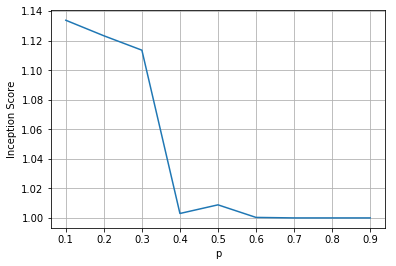

In [0]:
# plot Inception Score vs Block Probability
plt.plot(np.arange(0.1,1,0.1), np.array(mnist_score_lst))
plt.grid()
plt.xlabel('p')
plt.ylabel('Inception Score')
plt.show()